# Cultural Data Analysis

Introduction to working with datasets

In [1]:
# import necessary libraries
import os, re, csv
import pandas as pd
import numpy as np
import gensim, nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from itertools import islice

## Loading the dataset: heritage homes webistes

The dataset is stored in a shared google drive:
https://drive.google.com/drive/folders/11Shm0edDOiWrOe56fzJQRZi-v_BPSW8E?usp=drive_link

Add it to your drive.

To access it, load your gdrive in 'Files' (see left pane of the notebook in google colab) and navigate to the shared folder. You may need to click on 'refresh' to make it appear on the list.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
raw_data_file = '/content/gdrive/MyDrive/CDA/dataset_website-content-crawler_2024-11-13_22-29-32-301.json'

In [4]:
# Import json data from Aipfy scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df.head()

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,http://weldam.nl/,{'loadedUrl': 'http://weldam.nl/english/home.h...,{'canonicalUrl': 'http://weldam.nl/english/hom...,NaN,"Introduction - Weldam\nIntroduction\nWeldam, s...",# Introduction - Weldam\n\n### Introduction\n\...,{'requestHandlerMode': 'browser'}
1,http://weldam.nl/nederlands.html,{'loadedUrl': 'http://weldam.nl/nederlands.htm...,{'canonicalUrl': 'http://weldam.nl/nederlands....,NaN,Nederlands - Weldam\nCopyright Landgoed Weldam...,# Nederlands - Weldam\n\nCopyright Landgoed We...,{'requestHandlerMode': 'browser'}
2,http://weldam.nl/nederlands/beginpagina/test-2...,{'loadedUrl': 'http://weldam.nl/nederlands/beg...,{'canonicalUrl': 'http://weldam.nl/nederlands/...,NaN,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,# Test 1.2 - Weldam\n\nCopyright Landgoed Weld...,{'requestHandlerMode': 'browser'}
3,https://www.huisdoorn.nl/,"{'loadedUrl': 'https://www.huisdoorn.nl/', 'lo...","{'canonicalUrl': 'https://www.huisdoorn.nl/', ...",NaN,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,# Ontdek de geschiedenis - Museum Huis Doorn\n...,{'requestHandlerMode': 'browser'}
4,https://www.museumdefundatie.nl/,{'loadedUrl': 'https://www.museumdefundatie.nl...,{'canonicalUrl': 'https://www.museumdefundatie...,NaN,Museum de FundatieTwitter Widget Iframe\nMuseu...,# Museum de FundatieTwitter Widget Iframe\n\n!...,{'requestHandlerMode': 'browser'}


In [5]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s..."
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...


Join all pages from a domain to an entry in the analysis. To do this, add a new column which will contain only the main domain name.

In [6]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?:\w+\.)*\w+\.\w*', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [7]:
# Load the list of domains from a csv file:
nl = pd.read_csv('/content/gdrive/MyDrive/CDA/nl_urls.csv')
nl_urls = nl['NL domains'].values.tolist()

# Extract main domains from nl_urls
nl_domains = {extract_main_domain(url) for url in nl_urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in nl_domains]

In [8]:
print(len(matching_links))

10951


In [9]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

,url,text,domain
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s...",eldam.nl
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...,eldam.nl
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,eldam.nl
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,huisdoorn.nl
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...,museumdefundatie.nl


## Working with text

In [10]:
!wget https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/dutch.txt

--2024-11-14 00:08:13--  https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/dutch.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 453 [text/plain]
Saving to: ‘dutch.txt.3’

dutch.txt.3         100%[===================>]     453  --.-KB/s    in 0s      

2024-11-14 00:08:13 (25.5 MB/s) - ‘dutch.txt.3’ saved [453/453]



In [11]:
# load a list of 'stopwords' in the language you are analyzing
def get_stopwords_list(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))
stopwords_path = "dutch.txt"
stopwords = get_stopwords_list(stopwords_path)

In [12]:
special_stop_words = ['nbsp', 'the', 'and']
stopwords_ext = stopwords+special_stop_words

### Calculate term frequency, all

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cvec_all = CountVectorizer().fit(df.text)
df_matrix_all = cvec_all.transform(df.text)
df_all = np.sum(df_matrix_all,axis=0)
terms = np.squeeze(np.asarray(df_all))
print(terms.shape)
term_freq_df_all = pd.DataFrame([terms],columns=cvec_all.get_feature_names_out()).transpose() #term_freq_df is with stopwords
term_freq_df_all.columns = ['terms']
term_freq_df_all.sort_values(by='terms', ascending=False).iloc[:10]

(87327,)


,terms
de,108181
van,61552
en,58681
het,55170
in,45629
een,41790
is,26157
op,24681
voor,20211
met,19313


### Calculate term frequency without stop words

In [14]:
cvec_stopped = CountVectorizer(stop_words=stopwords_ext) # see above, import frozenset from stopwords_archive in correct language
cvec_stopped.fit(df.text)
document_matrix = cvec_stopped.transform(df.text)
term_batches = np.linspace(0,document_matrix.shape[0],10).astype(int)
i=0
df_stopped = []
while i < len(term_batches)-1:
    batch_result = np.sum(document_matrix[term_batches[i]:term_batches[i+1]].toarray(),axis=0)
    df_stopped.append(batch_result)
    print(term_batches[i+1],"entries' term frequency calculated")
    i += 1

terms_stopped = np.sum(df_stopped,axis=0)
print(terms_stopped.shape)
term_freq_df_stopped = pd.DataFrame([terms_stopped],columns=cvec_stopped.get_feature_names_out()).transpose()
term_freq_df_stopped.columns = ['terms']
term_freq_df_stopped.sort_values(by='terms', ascending=False).iloc[:10]

1216 entries' term frequency calculated
2433 entries' term frequency calculated
3650 entries' term frequency calculated
4867 entries' term frequency calculated
6083 entries' term frequency calculated
7300 entries' term frequency calculated
8517 entries' term frequency calculated
9734 entries' term frequency calculated
10951 entries' term frequency calculated
(87225,)


,terms
kasteel,17702
museum,7290
we,6922
00,5758
jaar,4568
onze,4167
2024,4027
uur,3858
to,3838
landgoed,3806


### Zipf's law

<ipython-input-26-380011d3677b>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frequencies = counts[indices]
<ipython-input-26-380011d3677b>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
<ipython-input-26-380011d3677b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],


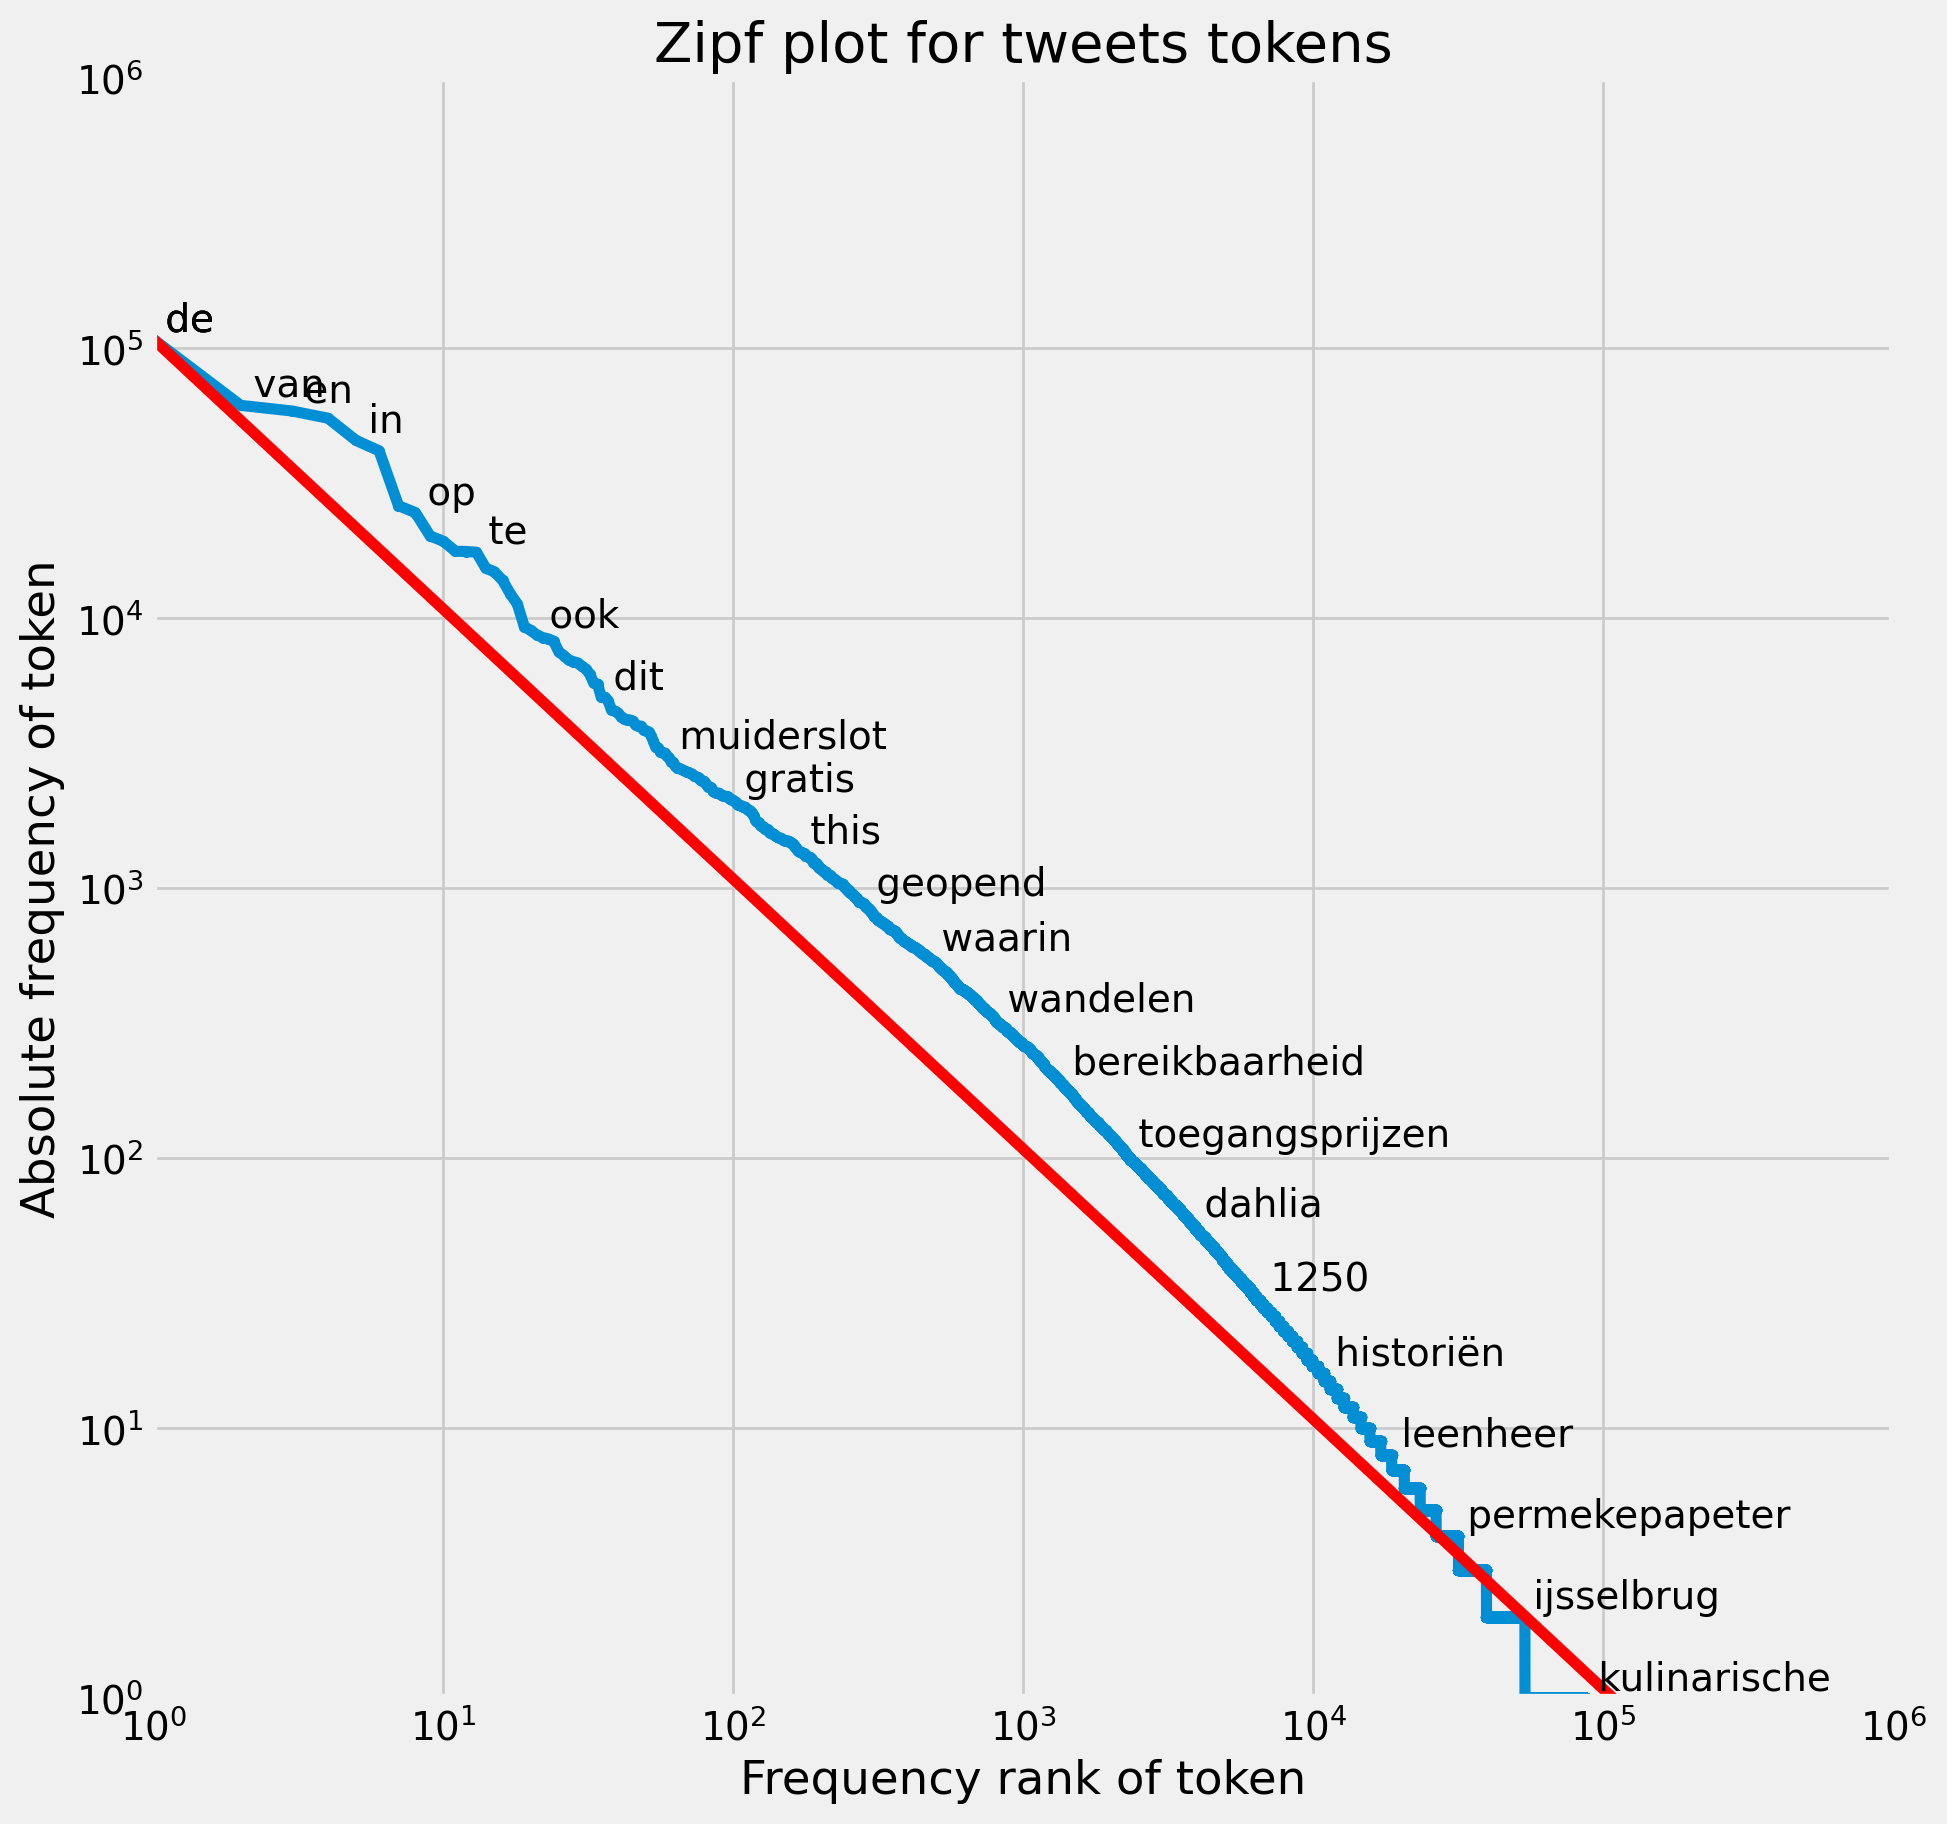

In [ ]:
# Plot Zipf's law table

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pylab import *
counts = term_freq_df_all.terms
tokens = term_freq_df_all.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(10,10))
plt.rc('font', size=14)
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],
                 verticalalignment="bottom",
                 horizontalalignment="left")

## Word2Vec model

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

# X is a list of tokenized texts (i.e. list of lists of tokens)
X = [word_tokenize(item) for item in df.text.tolist()]
#print(X[0:3])
model = gensim.models.Word2Vec(X, min_count=6, vector_size=200) # min_count: how many times a word appears in the corpus; size: number of dimensions

In [ ]:
model.wv.most_similar(positive=["kasteel"], topn=12)

[('huis', 0.7545874714851379),
 ('park', 0.7044533491134644),
 ('slot', 0.6809908151626587),
 ('terrein', 0.6436786651611328),
 ('landgoed', 0.625679612159729),
 ('dorp', 0.6219393610954285),
 ('Kasteel', 0.6121424436569214),
 ('Koetshuis', 0.6114010810852051),
 ('personeel', 0.5996105074882507),
 ('gebied', 0.5984265208244324),
 ('koetshuis', 0.5823447108268738),
 ('gebouw', 0.5678119659423828)]

## Collocations

In [ ]:
# SCI-KIT method, produces lists of co-occurencies for specific terms
def vectorize_text(df):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['text'])
    return X, vectorizer

# optional: calculate n most frequent words, returns a list
def get_most_frequent_words(vectorizer, X, n=5):
    word_counts = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    word_count_dict = dict(zip(words, word_counts))
    most_frequent_words = [word for word, count in Counter(word_count_dict).most_common(n)]
    #print(most_frequent_words, type(most_frequent_words))
    return most_frequent_words

# or use another list
search_words = ['architectuur', 'collectie', 'geschiedenis', 'tuin']

def find_collocations(text, target_words):
    words = text.split()
    collocations = []
    for i in range(len(words) - 1):
        if words[i] in target_words:
            collocations.append((words[i], words[i + 1]))
        if words[i + 1] in target_words:
            collocations.append((words[i + 1], words[i]))
    return collocations

def get_frequent_collocations(df, most_frequent_words):
    collocations = []
    for text in df['text']:
        collocations.extend(find_collocations(text, most_frequent_words))
    collocation_counts = Counter(collocations)
    frequent_collocations = {}
    for word in most_frequent_words:
        word_collocations = {collocation: count for collocation, count in collocation_counts.items() if word in collocation}
        frequent_collocations[word] = dict(islice(Counter(word_collocations).most_common(20), 20))
    return frequent_collocations

def analyze_word_collocations(df):
    X, vectorizer = vectorize_text(df)
    #most_frequent_words = get_most_frequent_words(vectorizer, X)
    most_frequent_words = search_words
    frequent_collocations = get_frequent_collocations(df, most_frequent_words)
    return frequent_collocations

In [ ]:
collocations24 = analyze_word_collocations(df_urled, family_words)

In [ ]:
data = []
for word, colloc_dict in collocations24.items():
   for collocation, count in colloc_dict.items():
       #collocation_str = ' '.join(collocation)  # Join collocation words into a single string
       data.append([word, collocation[1], count])
collocations24_df = pd.DataFrame(data, columns=['Word', 'Collocation', 'Count'])
print(collocations24_df.to_markdown(index=True))

|     | Word           | Collocation   |   Count |
|----:|:---------------|:--------------|--------:|
|   0 | kinder         | bruin         |       1 |
|   1 | kinder         | audiotour).   |       1 |
|   2 | spel           | het           |       4 |
|   3 | spel           | Het           |       2 |
|   4 | spel           | vrij          |       2 |
|   5 | spel           | en            |       2 |
|   6 | spel           | buiten        |       1 |
|   7 | spel           | gezet.        |       1 |
|   8 | spel           | op            |       1 |
|   9 | spel           | is            |       1 |
|  10 | spel           | gespeeld      |       1 |
|  11 | spel           | interessant   |       1 |
|  12 | spel           | met           |       1 |
|  13 | spel           | van           |       1 |
|  14 | spel           | hadden        |       1 |
|  15 | spel           | In            |       1 |
|  16 | spel           | in            |       1 |
|  17 | spel           | zet   

## TF-IDF vectorization

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords_ext)
# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df['text'])
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# Add filenames as index
tfidf_df.index = df['domain']
# Print the TF-IDF DataFrame
tfidf_df.head()

,00,000,0000,000000,0000000023,0000000357,0000000556,0000000557,0000000558,0000000561,...,𝙖𝙣𝙚𝙬,𝙗𝙚𝙣𝙚𝙖𝙩𝙝,𝙗𝙡𝙤𝙤𝙢,𝙜𝙚𝙢,𝙝𝙖𝙧𝙫𝙚𝙨𝙩𝙨,𝙝𝙪𝙚,𝙝𝙮𝙢𝙣,𝙢𝙤𝙤𝙣,𝙩𝙧𝙚𝙚𝙨,𝟮𝟬𝟮𝟰
domain,,,,,,,,,,,,,,,,,,,,,
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
huisdoorn.nl,0.046567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
museumdefundatie.nl,0.241849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Add column for document frequency aka number of times word appears in all documents
tfidf_df.loc['ALL'] = (tfidf_df > 0).sum()

In [18]:
tfidf_df.head() # first five rows

,00,000,0000,000000,0000000023,0000000357,0000000556,0000000557,0000000558,0000000561,...,𝙖𝙣𝙚𝙬,𝙗𝙚𝙣𝙚𝙖𝙩𝙝,𝙗𝙡𝙤𝙤𝙢,𝙜𝙚𝙢,𝙝𝙖𝙧𝙫𝙚𝙨𝙩𝙨,𝙝𝙪𝙚,𝙝𝙮𝙢𝙣,𝙢𝙤𝙤𝙣,𝙩𝙧𝙚𝙚𝙨,𝟮𝟬𝟮𝟰
domain,,,,,,,,,,,,,,,,,,,,,
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eldam.nl,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
huisdoorn.nl,0.046567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
museumdefundatie.nl,0.241849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# 10 most frequent words!

tfidf_slice = tfidf_df[term_freq_df_stopped.sort_values(by='terms', ascending=False).iloc[:10].index.tolist()]
tfidf_slice.sort_index().round(decimals=2).head() # first five rows

,kasteel,museum,we,00,jaar,onze,2024,uur,to,landgoed
domain,,,,,,,,,,
ALL,5318.00,2413.0,2615.0,1877.0,2725.0,2355.0,1207.0,1691.0,692.0,1260.0
artland.top,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
artland.top,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
artland.top,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
artland.top,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# reorganize the DataFrame so that the words are in rows rather than columns
tfidf_df = tfidf_df.drop('ALL', errors='ignore')
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df.head()

In [ ]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'domain': 'document','level_1': 'term'})
tfidf_df.head()

,document,term,tfidf
0,dekemastate.nl,00,0.0
1,dekemastate.nl,000,0.0
2,dekemastate.nl,0000,0.0
3,dekemastate.nl,0000000561,0.0
4,dekemastate.nl,0000000575,0.0


In [ ]:
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head

<bound method GroupBy.head of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x3085bae20>>

In [ ]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

# Terms in this list will get a red dot in the visualization
term_list = ['kasteel', 'huis']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)